In [1]:
import os
import json
import torch
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
from datasets import find_padding_masks

In [2]:
transformer_model = TransformerEncoder(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256,
                                    dropout=0.1, 
                                    freeze=False)
transformer_model.float()

# Load pretrained weights
transformer_model.load_state_dict(torch.load('../models/inputting_unity_norm.pt'))

<All keys matched successfully>

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 35 * 40, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

In [4]:
cnn_model = CNNModel()
cnn_model

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=89600, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [5]:
class CombinedModel(nn.Module):
    def __init__(self, transformer_model, cnn_model):
        super(CombinedModel, self).__init__()
        self.transformer_model = transformer_model
        self.cnn_model = cnn_model

    def forward(self, x, padding_mask):
        transformer_output = self.transformer_model(x, padding_mask)
        transformed_output = transformer_output.unsqueeze(1)
        logits_output = self.cnn_model(transformed_output)
        return logits_output

In [6]:
main_model = CombinedModel(transformer_model, cnn_model)
main_model

CombinedModel(
  (transformer_model): TransformerEncoder(
    (project_inp): Linear(in_features=35, out_features=64, bias=True)
    (pos_enc): LearnablePositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (output_layer): Linear(in_features

In [15]:
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
print(data_indices['val_indices'])

[247, 56, 297, 114, 313, 446, 258, 43, 133, 246, 242, 383, 413, 67, 8, 336, 152, 342, 272, 225, 257, 454, 26, 304, 269, 227, 458, 118, 27, 60, 338, 193, 433, 74, 191, 182, 175, 285, 139, 162, 208, 341, 33, 298, 173, 386, 451, 5, 23, 130, 343, 92, 107, 165, 280, 28, 226, 255, 197, 161, 379, 14, 214, 164, 231, 97, 170, 428, 287, 15, 288, 37, 71, 362, 123, 144, 174, 32, 61, 302, 399, 59, 111, 237, 44, 402, 366, 141, 334, 312, 436, 440, 475, 474, 380, 364, 240]


In [8]:
main_model.eval()
x, _, _ = next(iter(train_dataloader))
padding_mask = find_padding_masks(x)
x = torch.nan_to_num(x) # replace nan with 0 (since needs to be processed by the model)
probabilities = main_model(x, padding_mask)
probabilities

tensor([[0.2484, 0.2286],
        [0.2265, 0.1931],
        [0.1994, 0.1556],
        [0.2204, 0.1553],
        [0.2171, 0.1671],
        [0.2285, 0.2240],
        [0.2230, 0.1962],
        [0.2366, 0.2181],
        [0.2256, 0.1924],
        [0.2259, 0.2230]], grad_fn=<AddmmBackward0>)

In [11]:
def train_and_validate_classifier(model, train_loader, test_loader, n_epoch)

    best_test_loss = 1e20
    running_batch_loss_train = []
    running_batch_loss_test = []
    save_path = '../models/classification_unity_norm.pt'

    for epoch in range(n_epoch):
        print(f"Epoch: {epoch + 1}")

        # Train loop 
        for x, _, y in train_loader:
            padding_mask = find_padding_masks(x)
            x = torch.nan_to_num(x).to(device)
            y_hat = main_model(x, padding_mask).to(device)
            optimizer.zero_grad()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_batch_loss_train.append(loss.item())

        # Test loop
        for x, _, y in test_loader:
            padding_mask = find_padding_masks(x)
            x = torch.nan_to_num(x).to(device)
            y_hat = main_model(x, padding_mask).to(device)
            loss = criterion(y_hat, y)
            running_batch_loss_test.append(loss.item())

        # Save model if test loss is lower than best test loss
        if running_batch_loss_test[-1] < best_test_loss:
            best_test_loss = running_batch_loss_test[-1]
            torch.save(main_model.state_dict(), save_path)
            print(f"Saved model at epoch {epoch + 1}")

        # Print loss
        print(f"Train loss: {running_batch_loss_train[-1]}")
        print(f"Test loss: {running_batch_loss_test[-1]}")

    return running_batch_loss_train, running_batch_loss_test

n_epoch = 100
train_loader = train_dataloader
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_model.to(device)

train_loss, test_loss = train_and_validate_classifier(main_model, train_loader, train_loader, n_epoch)

Epoch: 1
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])


**Embeddings**

In [20]:
# Instantiate transformer model and load pretrained weights of best model on the classifciation task
main_model = CombinedModel(transformer_model, cnn_model)
main_model.load_state_dict(torch.load('../models/classification_standard_norm.pt'))
main_model.eval();

In [37]:
# Load trained weights of the transformer model

# Step 1: Create an instance of CombinedModel
transformer_model = TransformerEncoder(feat_dim=35,max_len=40,d_model=64,n_heads=8,num_layers=1,dim_feedforward=256,dropout=0.1,freeze=False).float()
cnn_model = CNNModel().float()
main_model = CombinedModel(transformer_model, cnn_model).float()

# Step 2: Load the weights for the entire combined model
main_model.load_state_dict(torch.load("../models/classification_standard_norm.pt"))

# Step 3: Remove the weights that belong to the cnn_model from the loaded state dict
state_dict = main_model.state_dict()
state_dict = {k: v for k, v in state_dict.items() if "cnn_model" not in k}

# Step 4: Load the modified state dict into the transformer_model
transformer_model.load_state_dict(state_dict, strict=False)

# Step 5: Set to eval mode
transformer_model.eval();

In [36]:
# Load train data
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=1, shuffle=False, drop_last=False)

# Load validation data
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
val_indices = data_indices['val_indices']
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=1, shuffle=False, drop_last=False)

In [36]:
import pandas as pd 
df = pd.read_csv(f'../data/long/{original_file_indx}.csv')
df.shape[0]

38

In [1]:
import os
import json
import torch
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
model = TransformerEncoder(feat_dim=35,
                           max_len=40,
                           d_model=35,
                           n_heads=7,
                           num_layers=1,
                           dim_feedforward=256,
                           dropout=0.1,
                           freeze=False).float()

In [3]:
inputs = torch.randn(1, 40, 35)
mask = torch.ones(1, 40).bool()
outputs, imbedding = model(inputs, mask)

In [4]:
outputs.shape, imbedding.shape

(torch.Size([1, 40, 35]), torch.Size([1, 40, 35]))

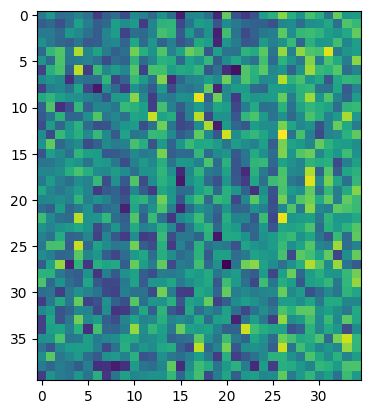

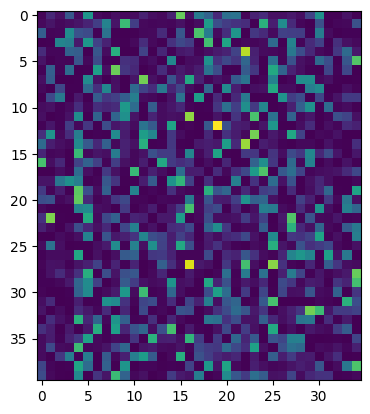

In [5]:
plt.imshow(outputs.detach().numpy()[0])
plt.show()

plt.imshow(imbedding.detach().numpy()[0])
plt.show()

**Create embedding dataset from trained transformer encoder**  
Must be the same format at original csv files

In [40]:
import os
import json
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
from datasets import find_padding_masks

In [48]:
# Get column names
df = pd.read_csv('../data/long/1.csv') # read in random file since all csv files have the same columns
features = df.columns.tolist()

In [49]:
# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, y = next(iter(dataloader))
print(data.shape, y)

torch.Size([485, 40, 35]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 

In [57]:
x = data[0].unsqueeze(0)
x.shape

torch.Size([1, 40, 35])

In [112]:
# Create the embeddings using the trained transformer model
transformer_model = TransformerEncoder(feat_dim=35,
                                       max_len=40,
                                       d_model=35,
                                       n_heads=7,
                                       num_layers=1,
                                       dim_feedforward=256,
                                       dropout=0.1,
                                       freeze=True).float()
transformer_model.eval();

indx = 0
for input, label in zip(data, y):
    label = label.item()
    input = input.unsqueeze(0)
    padding_mask = find_padding_masks(input)
    input = torch.nan_to_num(input)
    output, embedding = transformer_model(input, padding_mask)
    embedding = embedding.detach().numpy()[0]
    padding_mask = padding_mask.squeeze(0).detach().numpy()
    embedding = embedding[padding_mask]
    df = embedding_to_dataframe(embedding, features, label, indx)
    df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)
    df.rename(columns={'Unnamed: 0': ''}, inplace=True)
    df.to_csv(f'../data/embeddings/{indx}.csv', index=False)
    indx += 1
    break

torch.Size([1, 40, 35]) torch.Size([1, 40, 35])


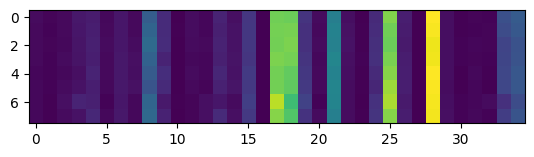

In [85]:
input = data[7].unsqueeze(0)
padding_mask = find_padding_masks(input)
input = torch.nan_to_num(input)
output, embedding = transformer_model(input, padding_mask)
embedding = embedding.detach().numpy()[0]
padding_mask = padding_mask.squeeze(0).detach().numpy()
embedding = embedding[padding_mask]

In [90]:
def embedding_to_dataframe(embedding, features, label, indx):
    """
    This function creates a pandas dataframe of the embeddings from transformer encoder that has been trained on the classifcation taks.
    The dataframe is of the same format as the original csv files.
    Args: embedding --> from trained transformer encoder ndarray(seq_len, d_model)
          features --> list of features from original csv file
          label --> Flare No-Flare binary label output from the dataloader 
          indx --> index of the original csv file         
    Output: pandas dataframe with the same format as the original csv files.
    """

    embedding = np.concatenate(
        (np.full((embedding.shape[0], 1), indx, dtype=int), embedding), axis=1) # add index column

    # add extra columns to match original csv file
    extra_cols = len(features) - embedding.shape[1] 
    extra_data = np.empty((embedding.shape[0], extra_cols))
    extra_data.fill(np.nan)
    modified_array = np.concatenate((embedding, extra_data), axis=1)

    # turn array into pandas dataframe and rename columns as well as add target values
    new_df = pd.DataFrame(modified_array, columns=features)
    new_df['R_VALUE'], new_df['XR_MAX'] = new_df['XR_MAX'], new_df['R_VALUE']
    new_df['target'] = label

    return new_df

In [17]:
df.head()

,Unnamed: 0,94,131,171,193,211,304,335,1600,1700,...,MEANJZH,TOTFY,MEANJZD,MEANALP,TOTFX,EPSY,EPSX,R_VALUE,XR_MAX,target
0,1,8.974219,29.204307,506.383286,818.701571,355.635094,105.700492,19.654783,77.338210,959.218468,...,0.012208,-1.082416e+23,0.050998,0.028371,-1.940120e+24,0.008031,0.143956,4.340293,4.854100e-07,1
1,1,10.126854,29.849536,496.012853,817.035740,356.629023,104.075087,20.269867,76.612126,963.786084,...,0.011820,-1.035303e+23,0.089647,0.027410,-1.934845e+24,0.007630,0.142551,4.338973,4.561938e-07,1
2,1,8.892889,27.052865,476.856401,792.896779,345.935345,96.576911,19.220694,75.617088,962.414683,...,0.011432,-9.881894e+22,0.128297,0.026448,-1.929571e+24,0.007229,0.141145,4.337653,4.269777e-07,1
3,1,8.569652,27.261664,483.389960,803.001028,349.442374,97.915371,19.269333,76.886881,959.575392,...,0.012075,-1.187114e+23,0.137501,0.027907,-1.899762e+24,0.008684,0.138957,4.346457,4.454338e-07,1
4,1,10.726769,30.501550,495.347490,828.010697,357.261581,101.980005,19.998163,77.086714,953.769573,...,0.012774,-1.399708e+23,0.145070,0.029499,-1.868590e+24,0.010242,0.136726,4.355824,4.665385e-07,1


**Grad-CAM**  
Problem is that not interpretable on the embeddings. Must either use CNN trained without transformer or make sure that the embedding discriminant region corresponds to that of the original mvts.

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from captum.attr import GuidedGradCam
from torch.utils.data import Dataset, DataLoader
from models import TransformerEncoder, CNNModel, CombinedModel
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

In [2]:
class CNNDataset(Dataset):
    '''
    Outputs a tuple of (x, y) where x is a tensor of shape (batch, features, time) and y is a tensor of shape (1,)
    Normalization is done per sample and is a unity normalization, i.e., no intensity infomation.
    '''
    def __init__(self, indices):
        super(CNNDataset, self).__init__()
        self.indices = indices

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        index = self.indices[idx]
        df = pd.read_csv(f'../data/embeddings/{index}.csv')
        if len(df) < 40:
            padding = pd.DataFrame(np.nan, index=np.arange(40 - len(df)), columns=df.columns)
            df = pd.concat([padding, df])

        label = df["target"].values[-1].astype(np.int64)
        df = df.drop("target", axis=1)
        df = df.drop("Unnamed: 0", axis=1)
        df = df.drop("R_VALUE", axis=1)
        embedding = np.array(df.values, dtype=np.float32)
        embedding_norm = embedding.T
        embedding_norm = self.unity_based_normalization(embedding_norm)
        embedding_norm = embedding_norm.T
        embedding = torch.tensor(embedding, dtype=torch.float32)
        embedding = torch.nan_to_num(embedding, nan=0)
        embedding = embedding.unsqueeze(0)
        embedding_norm = torch.tensor(embedding_norm, dtype=torch.float32)
        embedding_norm = torch.nan_to_num(embedding_norm, nan=0)

        return embedding, embedding_norm, label
    
    @staticmethod
    def unity_based_normalization(data):
        '''
        Normalize each row of the data matrix by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
        Takes in arrays of shape (features, time)
        This is just for visulization purposes, the CNN eats the raw embeddings without a normalization
        '''
        # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
        # Get the maximum and minimum values of each row
        max_vals = np.nanmax(data, axis=1)
        min_vals = np.nanmin(data, axis=1)
        # Compute the range of each row, and add a small constant to avoid division by zero
        ranges = max_vals - min_vals
        eps = np.finfo(data.dtype).eps  # machine epsilon for the data type
        ranges[ranges < eps] = eps
        # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
        data = (data - min_vals[:, np.newaxis]) / ranges[:, np.newaxis]
        data = data + np.nanmax(data)
        data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
        return data

In [3]:
# Create a model instance of the CNN and load the pretrained weights

# Step 1: Create an instance of the CombinedModel
transformer_model = TransformerEncoder(feat_dim=35,max_len=40,d_model=35,n_heads=7,num_layers=1,dim_feedforward=256,dropout=0.1,freeze=True).float()
cnn_model = CNNModel().float()
main_model = CombinedModel(transformer_model, cnn_model).float()

# Step 2: Load the weights for the entire combined model
main_model.load_state_dict(torch.load("../models/classification_standard_norm.pt"))

# Step 3: Remove the weights that belong to the transformer model from the loaded state dict
state_dict = main_model.state_dict()
state_dict = {k: v for k, v in state_dict.items() if "transformer_model" not in k}

# Step 4: Load the modified state dict into the cnn_model
cnn_model.load_state_dict(state_dict, strict=False)

# Step 5: Set to eval mode
cnn_model.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=89600, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [45]:
# Load data
Mydataset = CNNDataset(indices=[62])
train_dataloader = DataLoader(Mydataset, batch_size=1, shuffle=False)
embedding, embedding_norm, label = next(iter(train_dataloader))

In [46]:
# Create a GuidedGradCam object based on the model and the desired layer
guided_grad_cam = GuidedGradCam(cnn_model, cnn_model.conv2)

# Get the attribution mask
attribution_mask = guided_grad_cam.attribute(embedding.requires_grad_(), target=label.item()).detach()

/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [47]:
torch.nanmean(attribution_mask)
attribution_mask.shape

torch.Size([1, 1, 40, 35])

/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_7600/1410792091.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_7600/1410792091.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


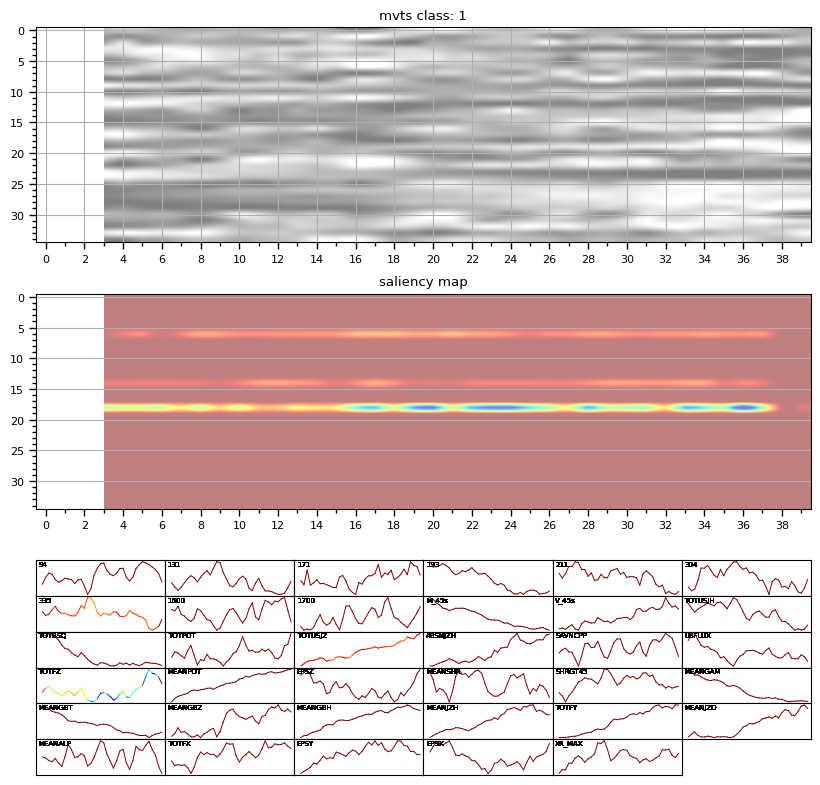

In [48]:
plt.rcParams['font.size'] = 8

name = '1'
class_name = str(label.detach().numpy().item())

dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
          'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
          'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
          'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']


embedding = embedding.squeeze().detach().numpy().copy().T
embedding_norm = embedding_norm.squeeze().detach().numpy().copy().T
attribution_mask = attribution_mask.squeeze().detach().numpy().copy().T

# nan out the padding
embedding[embedding==0] = np.nan
n_void = np.isnan(embedding[0]).sum()
attribution_mask[:,0:n_void] = np.nan
embedding_norm[embedding_norm==0] = np.nan


fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1, 1, 1], hspace=0.15, wspace=0.3)

# plot input mvt
ax1 = fig.add_subplot(gs[0:1, :])
ax1.set_title(f'mvts class: {class_name}')
ax1.imshow(embedding_norm, aspect='auto', cmap='gray', interpolation='spline16', alpha=0.5)
ax1.yaxis.grid(True, "major")
ax1.xaxis.grid(True, "major")
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)

# Plot saliency map
ax2 = fig.add_subplot(gs[1, :])
ax2.set_title('saliency map')
ax2.imshow(attribution_mask, aspect='auto', cmap='jet', alpha=0.5, interpolation='spline16')
ax2.yaxis.grid(True, "major")
ax2.xaxis.grid(False, "major")
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)

# Plot the light curves
gs2 = gridspec.GridSpecFromSubplotSpec(6, 6, subplot_spec=gs[2, 0:], wspace=0, hspace=0)
# Add the gridplot subplots
for i in range(6):
    for j in range(6):
        ind = (i * 6) + j
        if ind < len(dtypes):  # Check if index is within the range of dtypes
            ax = fig.add_subplot(gs2[i, j])
            # Handle NaN values in attribution_mask
            masked_mask = np.ma.masked_invalid(attribution_mask)
            # Normalize the masked_mask to range [0, 1]
            norm = mcolors.Normalize(vmin=masked_mask.min(), vmax=masked_mask.max())
            normalized_mask = norm(masked_mask)
            # Convert the normalized mask to RGB
            cmap = plt.cm.get_cmap('jet')
            rgb_colors = cmap(normalized_mask)
            light_curve = embedding[ind]
            light_curve_colors = rgb_colors[ind, :, :]
            for k, clr in enumerate(light_curve_colors):
                if k + 1 == 40: break
                x = [k, k+1]
                y = [light_curve[k], light_curve[k+1]]
                plt.plot(x, y, color=clr, linewidth=0.7)
                plt.text(0.02, 0.9, dtypes[ind], fontsize=5, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
                plt.xticks([])
                plt.yticks([])
                plt.xlim(0,40)
plt.tight_layout()
# plt.savefig(f'figs/{name}.png', bbox_inches='tight')
plt.show()
plt.close(fig)

In [167]:
# Load data 
Mydataset = CNNDataset(indices=[0])
train_dataloader = DataLoader(Mydataset, batch_size=1, shuffle=False)
embedding, embedding_norm, label = next(iter(train_dataloader))
embedding[embedding==0] = torch.nan
embedding_norm[embedding_norm==0] = torch.nan
print(label)

# Create a GuidedGradCam object based on the model and the desired layer
guided_grad_cam = GuidedGradCam(cnn_model, cnn_model.conv2)

# Get the attribution mask
attribution_mask = guided_grad_cam.attribute(embedding.requires_grad_(), target=label.item()).detach()

tensor([1])


/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [168]:
attribution_mask.shape

torch.Size([1, 1, 40, 35])

In [1]:
# fig, axs = plt.subplots(1, 3, figsize=(5, 6))
# axs[0].imshow(embedding[0, 0, :, :].detach().numpy(), aspect='auto', alpha=0.5, cmap='jet', interpolation='spline16')
# axs[1].imshow(embedding_norm[0, 0, :, :].detach().numpy(), aspect='auto', alpha=0.5, cmap='jet', interpolation='spline16')
# axs[2].imshow(attribution_mask[0, 0, :, :].detach().numpy() - attribution_mask[0, 0, :, :].numpy(), aspect='auto', alpha=0.5, cmap='jet', interpolation='spline16')
# plt.tight_layout()
# plt.show()

**Grad-CAM analysis 2**

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from captum.attr import GuidedGradCam
from torch.utils.data import Dataset, DataLoader
from models import CNNModel
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

from datasets import MVTSDataset
from captum.attr import GuidedGradCam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.size'] = 8

In [4]:
# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, labels = next(iter(dataloader))

In [15]:
# Load the best model
model = CNNModel()
model.load_state_dict(torch.load('../models/cnn_model_standard.pth'))
model.eval();

In [16]:
# Create a GuidedGradCam object based on the model and the desired layer
guided_grad_cam = GuidedGradCam(model, model.conv3)

In [19]:
for indx, (x, y) in enumerate(zip(data, labels)):
    if y.item() == 0: continue
    name = indices[indx]
    x = x.unsqueeze_(0)
    x = x.unsqueeze_(1)
    x = x.requires_grad_()
    x = torch.nan_to_num(x)
    attribution_mask = guided_grad_cam.attribute(x, target=y)
    x = x.squeeze().detach().numpy()
    attribution_mask = attribution_mask.squeeze().detach().numpy()  
    plot_attributions(x, attribution_mask, name=name)
    break


torch.Size([40, 1, 35])


In [40]:
def plot_attributions(mvts, attribution_mask, name=None):

    dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
            'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
            'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
            'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']

    mvts = mvts.T
    attribution_mask = attribution_mask.T


    mvts[mvts==0] = np.nan
    mvts = unity_based_normalization(mvts) # normalize the data so easier to see each feature in the original data

    n_void = np.isnan(mvts[0]).sum()

    fig = plt.figure(figsize=(10, 25))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1, 1, 1], hspace=0.15, wspace=0.3)

    # plot input mvt
    ax1 = fig.add_subplot(gs[0:1, :])
    ax1.set_title(f'mvts obs: {name}')
    ax1.imshow(mvts, aspect='auto', cmap='gray', interpolation='spline16', vmin=0, vmax=np.nanmax(mvts), alpha=0.5)
    ax1.yaxis.grid(True, "major")
    ax1.xaxis.grid(True, "major")
    ax1.xaxis.set_major_locator(MultipleLocator(2))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(1))
    ax1.tick_params(which='major', length=5,width=1)
    ax1.tick_params(which='minor', length=3,width=1)

    # Plot saliency map
    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('saliency map')
    attribution_mask[:,0:n_void] = np.nan
    ax2.imshow(attribution_mask, aspect='auto', cmap='jet', alpha=0.5, interpolation='spline16')
    ax2.yaxis.grid(True, "major")
    ax2.xaxis.grid(False, "major")
    ax2.xaxis.set_major_locator(MultipleLocator(2))
    ax2.xaxis.set_minor_locator(MultipleLocator(1))
    ax2.yaxis.set_major_locator(MultipleLocator(5))
    ax2.yaxis.set_minor_locator(MultipleLocator(1))
    ax2.tick_params(which='major', length=5,width=1)
    ax2.tick_params(which='minor', length=3,width=1)

    # Plot the light curves
    gs2 = gridspec.GridSpecFromSubplotSpec(6, 6, subplot_spec=gs[2, 0:], wspace=0, hspace=0)
    for i in range(6):
        for j in range(6):
            ind = (i * 6) + j
            if ind < len(dtypes):  # Check if index is within the range of dtypes
                ax = fig.add_subplot(gs2[i, j])
                # Handle NaN values in attribution_mask
                masked_mask = np.ma.masked_invalid(attribution_mask)
                # Normalize the masked_mask to range [0, 1]
                norm = mcolors.Normalize(vmin=masked_mask.min(), vmax=masked_mask.max())
                normalized_mask = norm(masked_mask)
                # Convert the normalized mask to RGB
                cmap = plt.cm.get_cmap('jet')
                rgb_colors = cmap(normalized_mask)
                light_curve = mvts[ind]
                light_curve_colors = rgb_colors[ind, :, :]
                for k, clr in enumerate(light_curve_colors):
                    if k + 1 == 40: break
                    x = [k, k+1]
                    y = [light_curve[k], light_curve[k+1]]
                    plt.plot(x, y, color=clr, linewidth=0.7)
                    plt.text(0.02, 0.9, dtypes[ind], fontsize=5, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
                    plt.xticks([])
                    plt.yticks([])
                    plt.xlim(0,40)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'../figs/grad_cam/{name}.png', bbox_inches='tight')
    plt.close(fig)

    return None

In [46]:
def unity_based_normalization(data):
    '''
    Normalize each row of the data matrix by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    Takes in arrays of shape (features, time)
    '''
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    # Get the maximum and minimum values of each row
    max_vals = np.nanmax(data, axis=1)
    min_vals = np.nanmin(data, axis=1)
    # Compute the range of each row, and add a small constant to avoid division by zero
    ranges = max_vals - min_vals
    eps = np.finfo(data.dtype).eps  # machine epsilon for the data type
    ranges[ranges < eps] = eps
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    data = (data - min_vals[:, np.newaxis]) / ranges[:, np.newaxis]
    data = data + np.nanmax(data)
    data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
    return data

In [16]:
x[:, -1]

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.0737792, 0.0737792, 0.0737792, 0.0737792,
       0.0737792, 0.0737792, 0.0737792, 0.0737792, 0.0737792, 0.0737792,
       0.0737792, 0.0737792, 0.0737792, 0.0737792, 0.0737792, 0.0737792,
       0.0737792, 0.0737792, 0.0737792, 0.0737792], dtype=float32)

In [18]:
import torch

# Create a tensor with shape (3, 4)
tensor = torch.tensor([[1, 2, 3, 4],
                       [5, 6, 7, 8],
                       [9, 10, 11, 12]])

# Select the column to be duplicated
source_column_index = 2
target_column_index = 3

# Copy the values of the source column
source_column = tensor[:, source_column_index]
tensor[:, target_column_index] = source_column

print(tensor)

tensor([[ 1,  2,  3,  3],
        [ 5,  6,  7,  7],
        [ 9, 10, 11, 11]])


In [3]:
import torch

# Create a tensor with shape (3, 4)
tensor = torch.tensor([[1, 2, 3, 4],
                       [5, 6, 7, 8],
                       [9, 10, 11, 12]])

# Get the number of columns
num_columns = tensor.shape[1]

# Generate random indices for shuffling along each column
shuffled_indices = torch.randperm(tensor.size(0))

# Create an indexing tensor for gather operation
indexing_tensor = torch.arange(num_columns).repeat(tensor.size(0), 1)

# Shuffle the elements along each column using gather
shuffled_tensor = torch.gather(tensor, 0, indexing_tensor[shuffled_indices, :])

print(shuffled_tensor)

In [31]:
import torch

# Create a tensor with shape (3, 4)
tensor = torch.tensor([[1, 2, 3, 4],
                       [5, 6, 7, 8],
                       [9, 10, 11, 12]])

# Get the number of columns
num_columns = tensor.shape[1]

# Shuffle the elements along each column
for i in range(num_columns):
    column = tensor[:, i]
    shuffled_indices = torch.randperm(column.size(0))
    tensor[:, i] = column[shuffled_indices]

print(tensor)


tensor([[ 1,  6, 11,  8],
        [ 9,  2,  7, 12],
        [ 5, 10,  3,  4]])


In [39]:
x[:,:,3]

tensor([[    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [-0.0654],
        [-0.0841],
        [-0.0940],
        [-0.0941],
        [-0.0760],
        [-0.0363],
        [-0.0374],
        [-0.0706],
        [ 0.0036],
        [-0.0854],
        [-0.0970],
        [-0.1030],
        [-0.0906],
        [-0.0969],
        [-0.0601],
        [-0.0972],
        [-0.1049],
        [-0.0957],
        [-0.1086],
        [-0.1094]])

**Feature Ranking**

In [4]:
import os 
import numpy as np
import pandas as pd

dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
        'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
        'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
        'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']

root_data_dir = '../data/attributions/'

dfs = []
x_all = None
for file in os.listdir(root_data_dir):
    if file.endswith('.npy'):
        x = np.load(root_data_dir + file, allow_pickle=True)
        try: x_all = np.concatenate((x_all, x), axis=0)
        except: x_all = x
        print(x_all.shape)

df = pd.DataFrame(x_all, columns=dtypes)
df = df.drop(columns=['TOTFX'])

(40, 35)
(80, 35)
(120, 35)
(160, 35)
(200, 35)
(240, 35)
(280, 35)
(320, 35)
(360, 35)
(400, 35)
(440, 35)
(480, 35)
(520, 35)
(560, 35)
(600, 35)
(640, 35)
(680, 35)
(720, 35)
(760, 35)
(800, 35)
(840, 35)
(880, 35)
(920, 35)
(960, 35)
(1000, 35)
(1040, 35)
(1080, 35)
(1120, 35)
(1160, 35)
(1200, 35)
(1240, 35)
(1280, 35)
(1320, 35)
(1360, 35)
(1400, 35)
(1440, 35)
(1480, 35)
(1520, 35)
(1560, 35)
(1600, 35)
(1640, 35)
(1680, 35)
(1720, 35)
(1760, 35)
(1800, 35)
(1840, 35)
(1880, 35)
(1920, 35)
(1960, 35)
(2000, 35)
(2040, 35)
(2080, 35)
(2120, 35)
(2160, 35)
(2200, 35)
(2240, 35)
(2280, 35)
(2320, 35)
(2360, 35)
(2400, 35)
(2440, 35)
(2480, 35)
(2520, 35)
(2560, 35)
(2600, 35)
(2640, 35)
(2680, 35)
(2720, 35)
(2760, 35)
(2800, 35)
(2840, 35)
(2880, 35)
(2920, 35)
(2960, 35)
(3000, 35)
(3040, 35)
(3080, 35)
(3120, 35)
(3160, 35)
(3200, 35)
(3240, 35)
(3280, 35)
(3320, 35)
(3360, 35)
(3400, 35)
(3440, 35)
(3480, 35)
(3520, 35)
(3560, 35)
(3600, 35)
(3640, 35)
(3680, 35)
(3720, 35)
(37

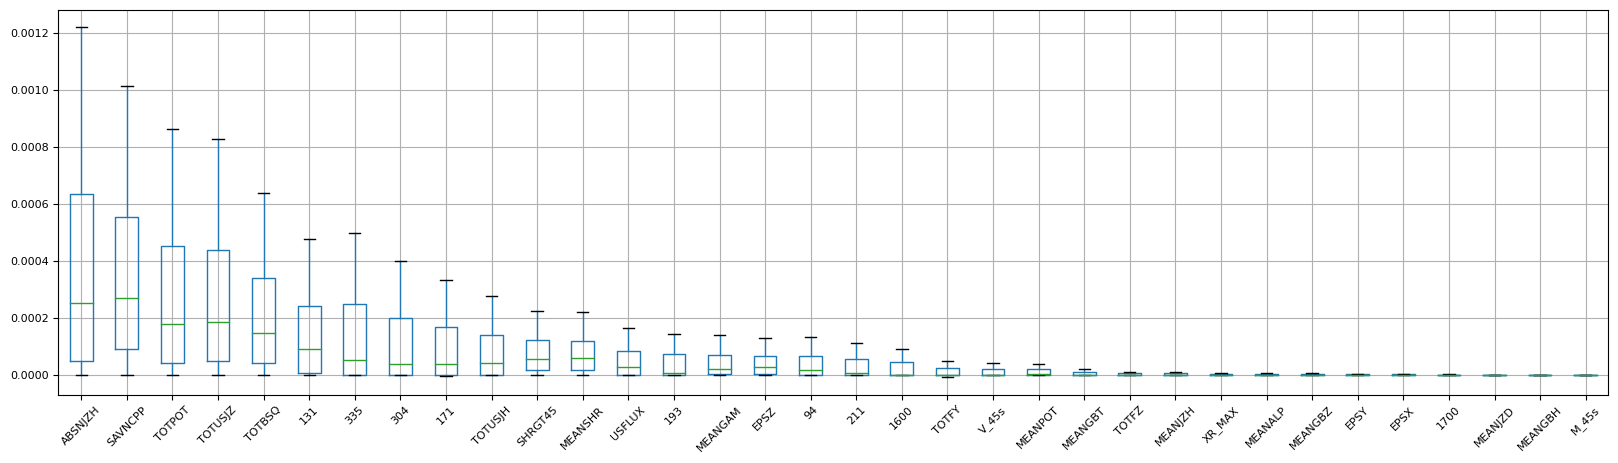

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 5))

# Calculate the mean values for each column
column_means = df.mean()

# Sort the columns based on mean values in descending order
sorted_columns = column_means.sort_values(ascending=False)

# Create a boxplot using the sorted column order
df_boxplot = df[sorted_columns.index].boxplot()

# Set the x-axis tick labels to the sorted column order
df_boxplot.set_xticklabels(sorted_columns.index, rotation=45)

# Filter outliers
threshold = 1.1  # Adjust this value as needed
for column in sorted_columns.index:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# plt.savefig('../figs/boxplot.png', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

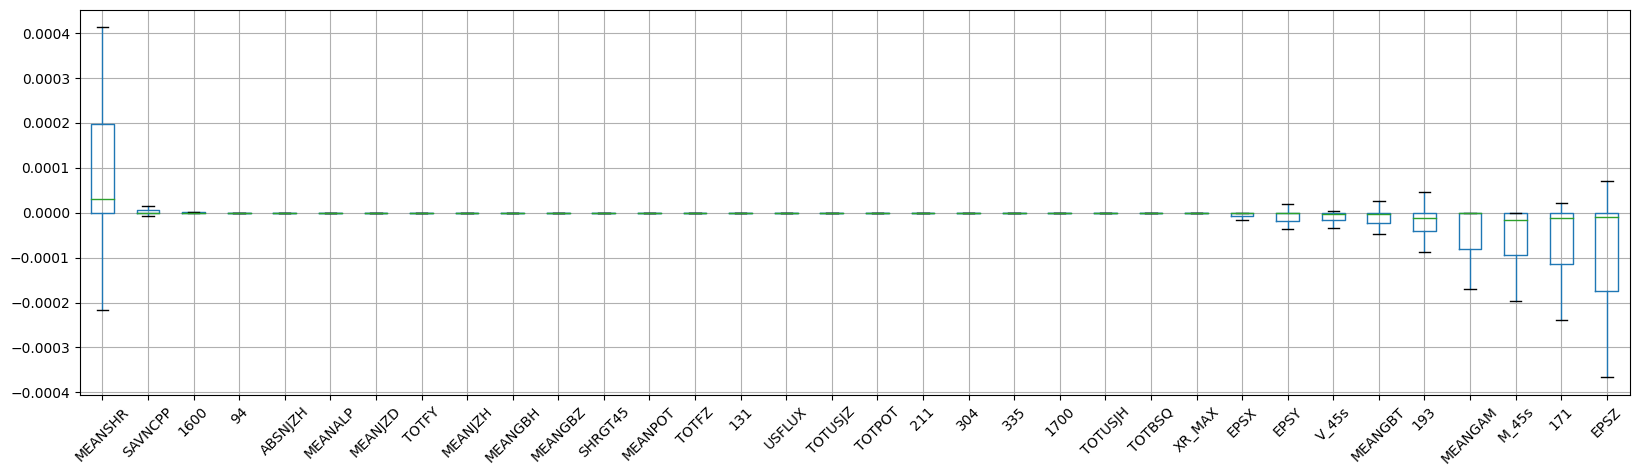

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 5))

# Calculate the mean values for each column
column_means = df.mean()

# Sort the columns based on mean values in descending order
sorted_columns = column_means.sort_values(ascending=False)

# Create a boxplot using the sorted column order
df_boxplot = df[sorted_columns.index].boxplot()

# Set the x-axis tick labels to the sorted column order
df_boxplot.set_xticklabels(sorted_columns.index, rotation=45)

# Filter outliers
threshold = 1.5  # Adjust this value as needed
for column in sorted_columns.index:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

plt.savefig('../figs/boxplot_embeddings.png', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

**Pair plot intensities**

In [2]:
import os
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler

In [3]:
# Collect all data into a single pandas dataframe
dataframes = []
for file_name in os.listdir('../data/long/'):
    df = pd.read_csv('../data/long/' + file_name)
    dataframes.append(df)
df = pd.concat(dataframes, ignore_index=True)
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop("R_VALUE", axis=1)
df.head()

,94,131,171,193,211,304,335,1600,1700,M_45s,...,MEANGBH,MEANJZH,TOTFY,MEANJZD,MEANALP,TOTFX,EPSY,EPSX,XR_MAX,target
0,2.918018,13.969911,369.098726,536.164432,218.309547,44.110328,9.737458,58.467420,841.730808,11.180648,...,43.304793,0.013500,-2.044535e+24,0.158671,0.037980,2.924329e+24,0.083483,-0.119407,5.421700e-07,1
1,2.911790,14.007880,370.015192,533.894009,217.293036,44.369353,9.724059,58.472574,843.415470,11.256843,...,43.481875,0.013258,-2.059398e+24,0.167709,0.037238,2.922138e+24,0.084189,-0.119457,5.482549e-07,1
2,2.949583,14.235638,370.676851,533.831950,217.638947,46.484114,9.713875,59.277822,844.331801,11.149372,...,43.658956,0.013016,-2.074260e+24,0.176747,0.036497,2.919948e+24,0.084895,-0.119507,5.543397e-07,1
3,3.283343,15.586344,380.975903,541.843027,220.404853,48.999401,9.899407,60.045933,844.739337,11.103078,...,43.696922,0.012826,-2.079820e+24,0.137492,0.035991,2.916506e+24,0.085127,-0.119373,6.350000e-07,1
4,4.198611,15.290191,369.267858,535.291171,218.931543,45.349041,10.267297,59.026293,842.802945,11.199798,...,43.727159,0.012640,-2.084862e+24,0.095555,0.035497,2.912995e+24,0.085333,-0.119228,7.198033e-07,1


In [1]:
sns.pairplot(df, hue='target')

**Calculate probability curves**

In [160]:
import os
import numpy as np 
import matplotlib.pyplot as plt

In [161]:
path_to_attributions = '../kfold/attributions/'

attribution_masks = []
for file in os.listdir(path_to_attributions):
    if file.endswith('.npy'):
        attribution_mask = np.load(path_to_attributions + file, allow_pickle=True)

        min_val = np.nanmin(attribution_mask)
        attribution_mask = attribution_mask + np.abs(min_val)
        max_val = np.nanmax(attribution_mask)
        attribution_mask = attribution_mask / max_val
        attribution_mask = attribution_mask.T
        attribution_masks.append(attribution_mask)

attribution_masks = np.vstack(attribution_masks)
# attribution_masks[attribution_masks == 0] = np.nan
print(attribution_masks.shape)


(8540, 40)


In [162]:
means = np.nanmean(attribution_masks, axis=0)
stds = np.nanstd(attribution_masks, axis=0)
print(means.shape, stds.shape)

(40,) (40,)


In [163]:
# Running k-fold wil make the variance smaller 

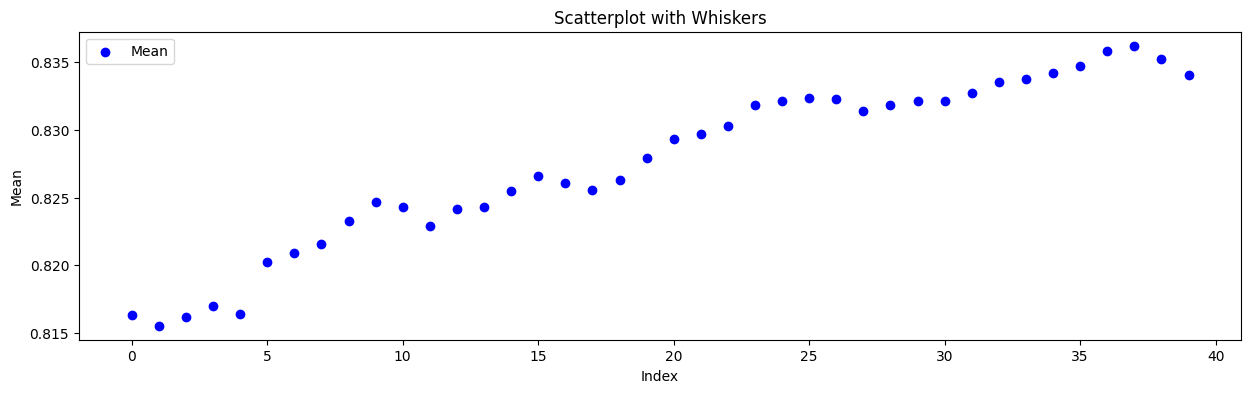

In [166]:
# Create the scatterplot
fig, ax = plt.subplots(figsize=(15, 4))

# Plot the means
ax.scatter(range(len(means)), means, color='b', label='Mean')


# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Mean')
ax.set_title('Scatterplot with Whiskers')

# Display the legend
ax.legend()

# Show the plot
plt.show()

In [18]:
attribution_mask

array([[-7.9617726e-09,  5.0914377e-08, -1.0103751e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 6.4126503e-08,  7.1950851e-08, -2.0652310e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.0698806e-07,  2.5818628e-07, -3.4338916e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 8.9344830e-06,  4.2294181e-05,  6.9438058e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.8030682e-06,  3.2655393e-05,  5.0452752e-05, ...,
         0.0000000e+00,  0.0000000e+00,  5.8391464e-07],
       [ 3.0655208e-06,  1.0398929e-05,  1.8769340e-05, ...,
         0.0000000e+00,  0.0000000e+00,  1.3486890e-07]], dtype=float32)

In [40]:
import numpy as np
from sklearn.model_selection import KFold

indices = np.arange(0, 485, 1)
kf = KFold(n_splits=10)

for i, (train_index, test_index) in enumerate(kf.split(indices)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
print(len(test_index)/len(indices) *100)

Fold 0:
  Train: index=[ 49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289

In [47]:
import json
# Read in train and validation indices
with open('../data/data_indices.json', 'r') as f:
    data_indices = json.load(f)
train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']
print(len(val_indices) / len(train_indices)*100)

25.0


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

indices = np.arange(0, 485, 1)

X_train, X_test = train_test_split(indices, test_size=0.25, shuffle=True)

col = []
for i in range(1000):
    X_train, X_test = train_test_split(indices, test_size=0.25, shuffle=True)


**Metrics**

In [2]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import MVTSDataset
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator
from models import CNNModel
from sklearn import metrics

In [4]:
# Load model 
def get_model(model_type: str) -> torch.nn: 
    """
    Here we load the model. 
    """

    from models import CNNModel, TransformerEncoder, CombinedModel

    if model_type == 'cnn':
        model = CNNModel()
        path_to_best_model = '../models/cnn_model_standard.pth'

    if model_type == 'combined':
        transformer_model = TransformerEncoder(feat_dim=35,
                                                max_len=40,
                                                d_model=35,
                                                n_heads=7,
                                                num_layers=1,
                                                dim_feedforward=256,
                                                dropout=0.1,
                                                freeze=False)
        cnn_model = CNNModel()
        model = CombinedModel(transformer_model, cnn_model)
        path_to_best_model = '../models/classification_standard_norm.pt'
        
    model.load_state_dict(torch.load(path_to_best_model))
    model.eval();
        
    return model

model = get_model('combined');

In [5]:
# get predictions

# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, labels = next(iter(dataloader))
data = torch.nan_to_num(data)
padding_mask = torch.ones(485, 40).bool()

logits = model(data, padding_mask) # Get logits
probabilities = F.softmax(logits, dim=1) # Apply softmax function to logits
y_hat = probabilities[:, 1].detach().numpy() # Extract the probability for the positive class
y_true = labels.detach().numpy() # Extract the true labels

print(np.round(y_hat,2))
print(y_true)

[0.6  0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   0.98 1.   0.98 1.   1.   0.99 1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   0.98 1.   1.   1.   1.
 1.   0.99 0.94 0.54 1.   1.   1.   1.   1.   1.   1.   1.   1.   0.98
 0.99 0.92 1.   1.   1.   1.   0.97 1.   0.95 1.   0.93 0.79 1.   1.
 1.   0.99 0.95 1.   1.   1.   1.   1.   0.99 0.96 1.   1.   1.   0.99
 1.   1.   1.   0.85 1.   1.   0.99 1.   0.68 1.   1.   1.   0.99 0.99
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   0.89 1.   1.   1.   1.   0.96 1.   1.   0.97 0.63 1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.21 1.
 0.38 1.   0.99 1.   0.96 1.   0.67 1.   1.   1.   1.   0.98 0.99 1.
 1.   1.   1.   0.99 1.   1.   1.   1.   0.89 1.   1.   1.   1.   1.
 1.   1.   0.88 0.98 0.99 0.97 1.   1.   1.   1.   1.   1.   1.   0.99
 1.   1.   0.98 1.   0.96 1.   1.   1.   1.   1.   1.   0.28 1.   0.99
 1.   1.   1.   1.   0.9

In [6]:
# Calculate metrics 

# Step 1: Calculate Brier skill score
def calculate_brier_skill_score(y_true, y_hat):
    brier_score = ((y_true - y_hat) ** 2).mean()
    climatology_brier_score = ((y_true.mean() - y_true) ** 2).mean()
    brier_skill_score = 1 - (brier_score / climatology_brier_score)
    return brier_skill_score

brier_skill_score = calculate_brier_skill_score(y_true, y_hat)

In [2]:
brier_skill_score

NameError: name 'brier_skill_score' is not defined

In [58]:
# Step 2: Plot reliability diagram
def plot_reliability_diagram(y_true, y_hat):
    bins = np.linspace(0, 1, num=10)  # Adjust the number of bins as needed

    bin_avg_forecast_probs = np.histogram(y_hat, bins=bins, weights=y_hat)[0] / np.histogram(y_hat, bins=bins)[0]
    bin_observed_freqs = np.histogram(y_hat, bins=bins, weights=y_true)[0] / np.histogram(y_hat, bins=bins)[0]

    plt.plot(bin_avg_forecast_probs, bin_observed_freqs, marker='o', linestyle='-', color='b')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Add the diagonal reference line
    plt.xlabel('Forecast Probability')
    plt.ylabel('Observed Relative Frequency')
    plt.title('Reliability Diagram')
    plt.show()

    return None

In [105]:
# Step 2: Plot reliability diagram with shaded region
def plot_reliability_diagram(y_true, y_hat):
    bins = np.linspace(0, 1, num=10)  # Adjust the number of bins as needed

    bin_avg_forecast_probs = np.histogram(y_hat, bins=bins, weights=y_hat)[0] / np.histogram(y_hat, bins=bins)[0]
    bin_observed_freqs = np.histogram(y_hat, bins=bins, weights=y_true)[0] / np.histogram(y_hat, bins=bins)[0]

    # Calculate Brier Skill Score
    brier_skill = np.round(calculate_brier_skill_score(y_true, y_hat),2)

    fig, ax = plt.subplots(figsize=(5, 6))

    plt.plot(bin_avg_forecast_probs, bin_observed_freqs, linestyle='--', color='k')
    plt.plot([0, 1], [0, 1], linestyle=':', color='k')  # Add the diagonal reference line
    plt.fill_between(bin_avg_forecast_probs, bin_observed_freqs, bin_avg_forecast_probs, where=(bin_avg_forecast_probs > bin_observed_freqs), alpha=0.2, color='k')
    plt.text(0.05, 0.95, f'Brier Skill Score: {brier_skill}', fontsize=10, horizontalalignment='left', verticalalignment='top')
    plt.xlabel('Forecast Probability')
    plt.ylabel('Observed Relative Frequency')

    ax.xaxis.set_major_locator(MultipleLocator(.1))
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.yaxis.set_major_locator(MultipleLocator(.1))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.tick_params(which='major', length=5,width=1)
    ax.tick_params(which='minor', length=3,width=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return None

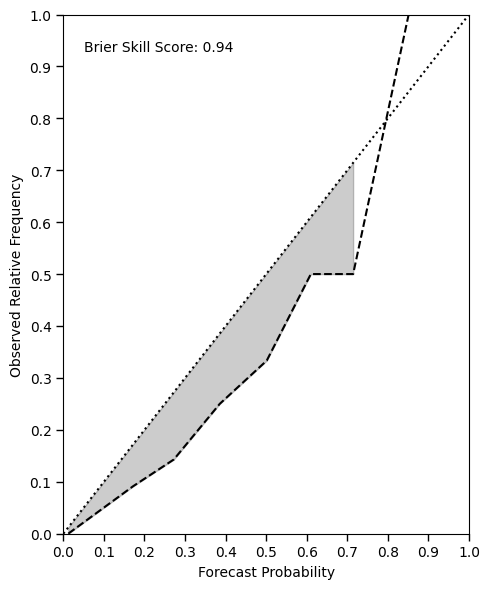

In [106]:
# Plot reliability diagram
plot_reliability_diagram(y_true, y_hat)
# climatology --> reference forecast that consistently predicts the average event frequency

In [21]:
path_to_splits = '../kfold/splits/'
file_names = np.arange(0, 50, 1)
file_names = np.delete(file_names, np.argwhere(file_names == 27))
file_names = np.delete(file_names, np.argwhere(file_names == 37))
file_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [50]:
# Initialize lists to store metrics

running_acc_val = []
running_acc_train = []

running_tss_val = []
running_tss_train = []

running_bss_val = []
running_bss_train = []

running_auc_val = []
running_auc_train = []

running_brier_skill_scores_val = []
running_brier_skill_scores_train = []


for file_name in file_names:

    # Load split indices
    path = path_to_splits + 'fold_' + str(file_name) + '.npz'
    fhand = np.load(path)
    val_indices = fhand['val_indices']
    train_indices = fhand['train_indices']

    # Create dataloaders
    val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=len(val_indices), shuffle=False, drop_last=False)
    train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=len(train_indices), shuffle=False, drop_last=False)

    # Load data
    data_val, _, labels_val = next(iter(val_dataloader))
    data_val = torch.nan_to_num(data_val)
    data_val = data_val.unsqueeze_(1)
    data_train, _, labels_train = next(iter(train_dataloader))
    data_train = data_train.unsqueeze_(1)
    data_train = torch.nan_to_num(data_train)

    # Load model
    model = CNNModel()
    path = '../kfold/models/cnn_model_standard_' + str(file_name) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    # Calculate y_hat and y_true for both train and validation sets
    logits_val = model(data_val)
    probabilities_val = F.softmax(logits_val, dim=1) 
    y_hat_val = probabilities_val[:, 1].detach().numpy() 
    y_true_val = labels_val.detach().numpy() # Extract the true labels

    logits_train = model(data_train)
    probabilities_train = F.softmax(logits_train, dim=1)
    y_hat_train = probabilities_train[:, 1].detach().numpy()
    y_true_train = labels_train.detach().numpy()

    # Apply metrics
    accuracy_val = accuracy(y_true_val, y_hat_val)
    accuracy_train = accuracy(y_true_train, y_hat_train)

    hss_val = hss(y_true_val, y_hat_val)
    hss_train = hss(y_true_train, y_hat_train)

    tss_val = tss(y_true_val, y_hat_val)
    tss_train = tss(y_true_train, y_hat_train)

    auc_val = roc_auc_score(y_true_val, y_hat_val)
    auc_train = roc_auc_score(y_true_train, y_hat_train)

    brier_skill_score_val = calculate_brier_skill_score(y_true_val, y_hat_val)
    brier_skill_score_train = calculate_brier_skill_score(y_true_train, y_hat_train)

    # Append metrics to lists
    running_acc_val.append(accuracy_val)
    running_acc_train.append(accuracy_train)

    running_tss_val.append(tss_val)
    running_tss_train.append(tss_train)

    running_bss_val.append(brier_skill_score_val)
    running_bss_train.append(brier_skill_score_train)

    running_auc_val.append(auc_val)
    running_auc_train.append(auc_train)

    running_brier_skill_scores_val.append(brier_skill_score_val)
    running_brier_skill_scores_train.append(brier_skill_score_train)


# Store metics in a dictionary and save to disk
metrics = {'running_acc_val': running_acc_val,
           'running_acc_train': running_acc_train,
            'running_auc_val': running_auc_val,
            'running_auc_train': running_auc_train,
           'running_tss_val': running_tss_val,
           'running_tss_train': running_tss_train,
           'running_bss_val': running_bss_val,
           'running_bss_train': running_bss_train,
           'running_brier_skill_scores_val': running_brier_skill_scores_val,
           'running_brier_skill_scores_train': running_brier_skill_scores_train
        }

In [57]:
# Metrics


# Function to calculate AUC
def roc_auc_score(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

# Function to calculate accuracy
def accuracy(y_true, y_hat):
    y_pred = np.where(y_hat >= 0.5, 1, 0)  # Thresholding at 0.5 to convert into binary predictions
    total_samples = len(y_true)
    correct_predictions = np.sum(y_true == y_pred)
    accuracy_score = correct_predictions / total_samples
    return accuracy_score

# Function to calculate the Brier skill score
def calculate_brier_skill_score(y_true, y_hat):
    brier_score = ((y_true - y_hat) ** 2).mean()
    climatology_brier_score = ((y_true.mean() - y_true) ** 2).mean()
    brier_skill_score = 1 - (brier_score / climatology_brier_score)
    return brier_skill_score

# Function to calculate HSS (Cohen's kappa coefficient)
def hss(y_true, y_hat):
    y_pred = np.where(y_hat >= 0.5, 1, 0)  # Thresholding at 0.5 to convert into binary predictions
    total_samples = len(y_true)
    a = np.sum(y_true == 1)  # Number of true positive predictions
    b = np.sum(y_true == 0)  # Number of true negative predictions
    c = np.sum(y_pred == 1)  # Number of positive predictions
    d = np.sum(y_pred == 0)  # Number of negative predictions
    p0 = (a + b) / total_samples  # Overall agreement
    pe = ((a + c) * (a + b) + (b + d) * (c + d)) / (total_samples ** 2)  # Expected agreement by chance
    hss_score = (p0 - pe) / (1 - pe)  # HSS score
    return hss_score

# Function to calculate TSS (Hanssen & Kuiper's skill score or Peirce skill score)
def tss(y_true, y_hat):
    y_pred = np.where(y_hat >= 0.5, 1, 0)  # Thresholding at 0.5 to convert into binary predictions
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True positives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True negatives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False positives
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False negatives
    hit_rate = tp / (tp + fn)  # True Positive Rate (TPR) or Hit Rate
    false_alarm_rate = fp / (fp + tn)  # False Positive Rate (FPR) or False Alarm Rate
    tss_score = hit_rate - false_alarm_rate  # True Skill Score (TSS)
    return tss_score


accuracy_val = accuracy(y_true_val, y_hat_val)
accuracy_train = accuracy(y_true_train, y_hat_train)

hss_val = hss(y_true_val, y_hat_val)
hss_train = hss(y_true_train, y_hat_train)

tss_val = tss(y_true_val, y_hat_val)
tss_train = tss(y_true_train, y_hat_train)

brier_skill_score_val = calculate_brier_skill_score(y_true_val, y_hat_val)
brier_skill_score_train = calculate_brier_skill_score(y_true_train, y_hat_train)

In [54]:
print('Accuracy (validation):', accuracy_val)
print('Accuracy (train):', accuracy_train)
print('HSS (validation):', hss_val)
print('HSS (train):', hss_train)
print('TSS (validation):', tss_val)
print('TSS (train):', tss_train)
print('Brier skill score (validation):', brier_skill_score_val)
print('Brier skill score (train):', brier_skill_score_train)

Accuracy (validation): 0.8934426229508197
Accuracy (train): 1.0
HSS (validation): 1.0
HSS (train): 1.0
TSS (validation): 0.7827260458839407
TSS (train): 1.0
Brier skill score (validation): 0.58943087772539
Brier skill score (train): 0.9881175353392756


In [64]:
import pandas as pd
import pickle

# Load the data from the pickle file
with open('../data/metrics_standard_cnn.pkl', 'rb') as f:
    data = pickle.load(f)

auc_values = data['running_auc_val']
tss_values = data['running_tss_val']
acc_values = data['running_acc_val']
bss_values = data['running_bss_val']

import plotly.express as px

# Create a DataFrame with the metric values
df = pd.DataFrame({
    'auc': auc_values,
    'tss': tss_values,
    'acc': acc_values,
    'bss': bss_values
})

# Create the Parallel Coordinates plot using Plotly
fig = px.parallel_coordinates(df, color='bss')

# Set the title
fig.update_layout(title='Parallel Coordinates Plot for Metrics')

# Display the plot
fig.show()


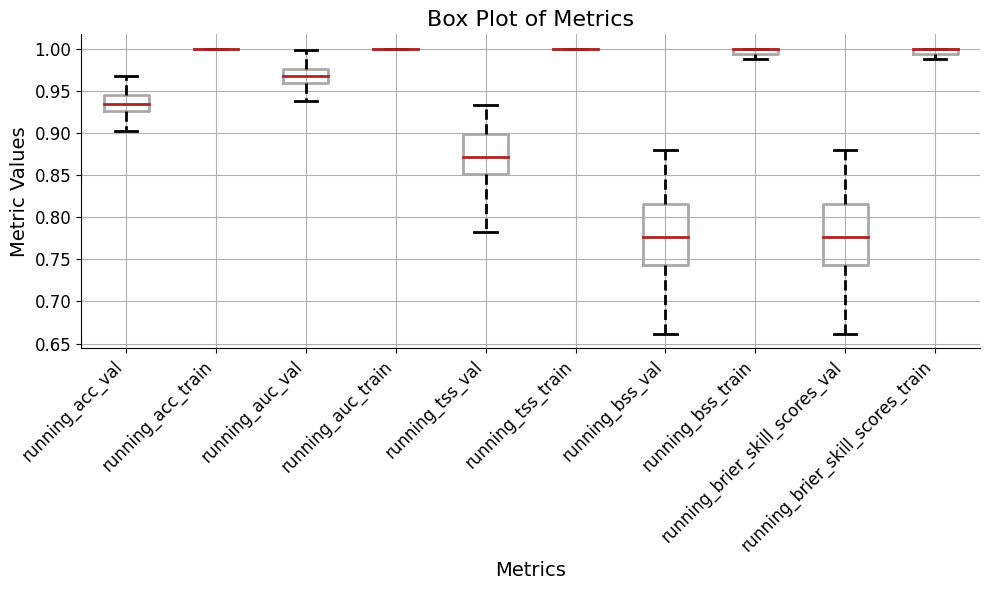

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Load the metrics from the pickle file
with open('../data/metrics_standard_cnn.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Create a DataFrame from the metrics dictionary
df = pd.DataFrame(metrics)

# Set the figure size and background color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('w')

# Set the title and axis labels
plt.title('Box Plot of Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Metric Values', fontsize=14)

# Customize the boxplot appearance
boxprops = dict(linewidth=2, color='darkgray')
medianprops = dict(linewidth=2, color='firebrick')
whiskerprops = dict(linewidth=2, color='black', linestyle='--')
capprops = dict(linewidth=2, color='black')

# Create the boxplot
df.boxplot(ax=ax, boxprops=boxprops, medianprops=medianprops,
           whiskerprops=whiskerprops, capprops=capprops,
           showfliers=False)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()


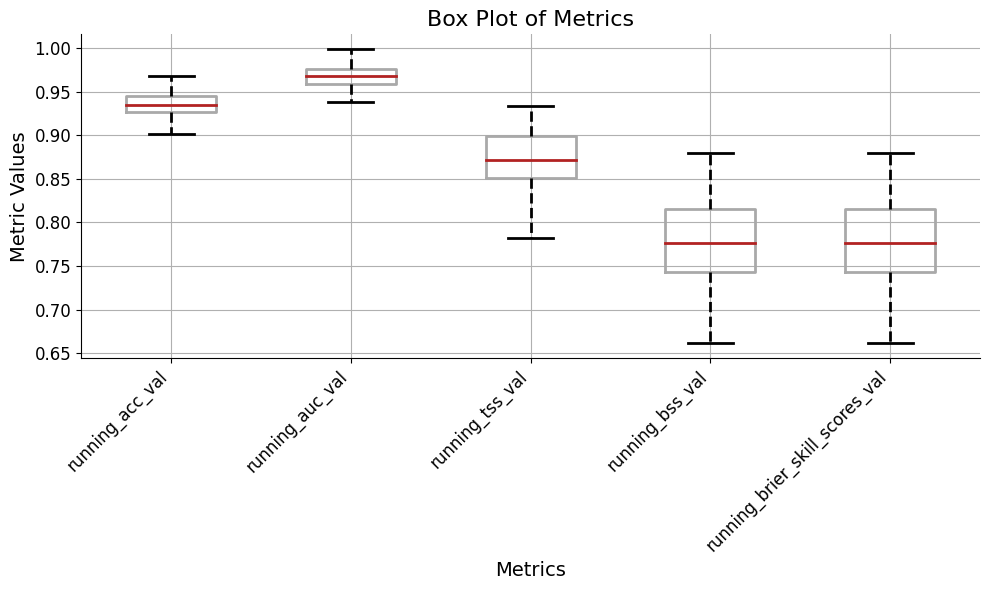

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Load the metrics from the pickle file
with open('../data/metrics_standard_cnn.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Remove train metrics from the dictionary
metrics_validation = {key: value for key, value in metrics.items() if 'train' not in key}

# Create a DataFrame from the validation metrics dictionary
df = pd.DataFrame(metrics_validation)

# Set the figure size and background color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('w')

# Set the title and axis labels
plt.title('Box Plot of Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Metric Values', fontsize=14)

# Customize the boxplot appearance
boxprops = dict(linewidth=2, color='darkgray')
medianprops = dict(linewidth=2, color='firebrick')
whiskerprops = dict(linewidth=2, color='black', linestyle='--')
capprops = dict(linewidth=2, color='black')

# Create the boxplot
df.boxplot(ax=ax, boxprops=boxprops, medianprops=medianprops,
           whiskerprops=whiskerprops, capprops=capprops,
           showfliers=False)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()

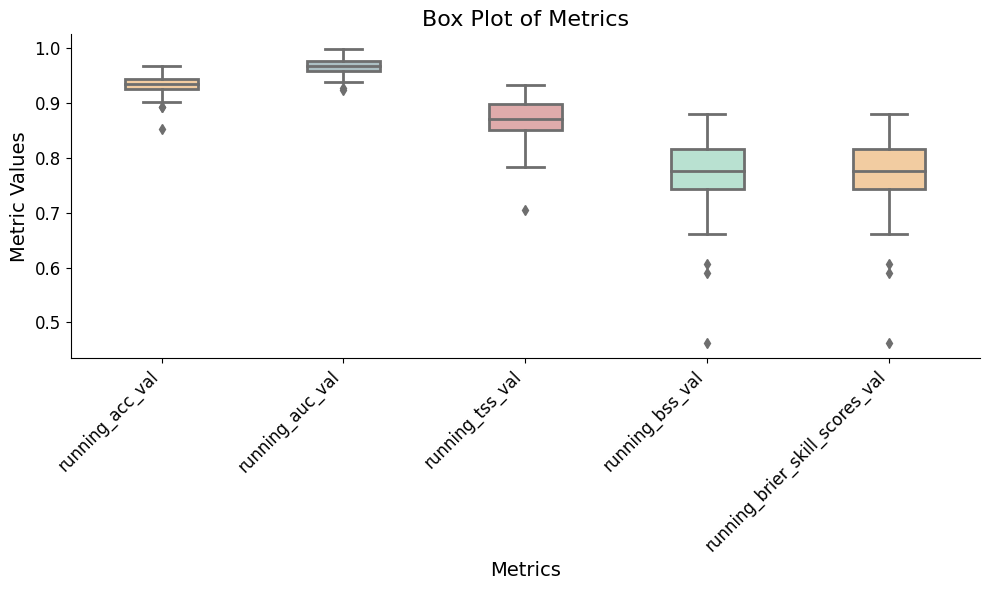

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# Load the metrics from the pickle file
with open('../data/metrics_standard_cnn.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Remove train metrics from the dictionary
metrics_validation = {key: value for key, value in metrics.items() if 'train' not in key}

# Create a DataFrame from the validation metrics dictionary
df = pd.DataFrame(metrics_validation)

# Set the figure size and background color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('w')

# Set the title and axis labels
plt.title('Box Plot of Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Metric Values', fontsize=14)

# Create a palette of vintage pastel colors
colors = ['#ffcd94', '#a8c1c7', '#e8a3a2', '#b2e8d2']

# Create the boxplot with adjusted box width and vintage pastel colors
sns.boxplot(data=df, ax=ax, width=0.4, palette=colors, linewidth=2)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()


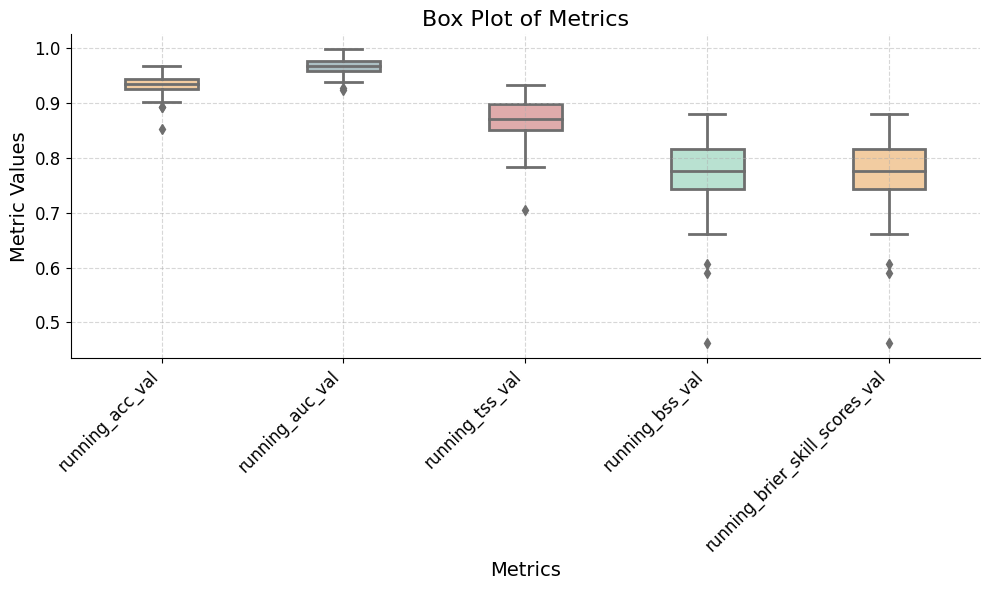

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# Load the metrics from the pickle file
with open('../data/metrics_standard_cnn.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Remove train metrics from the dictionary
metrics_validation = {key: value for key, value in metrics.items() if 'train' not in key}

# Create a DataFrame from the validation metrics dictionary
df = pd.DataFrame(metrics_validation)

# Set the figure size and background color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('w')

# Set the title and axis labels
plt.title('Box Plot of Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Metric Values', fontsize=14)

# Create a palette of vintage pastel colors
colors = ['#ffcd94', '#a8c1c7', '#e8a3a2', '#b2e8d2']

# Create the boxplot with adjusted box width and vintage pastel colors
sns.boxplot(data=df, ax=ax, width=0.4, palette=colors, linewidth=2)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add a grid on the background
ax.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()


**kfold combined model**

In [2]:
import torch
import numpy as np
import torch.nn as nn
from models import CNNModel
from datasets import MVTSDataset
from torch.utils.data import DataLoader
from datasets import find_padding_masks
from models import TransformerEncoder, CNNModel, CombinedModel

In [96]:
def train():
    model.train()
    train_loss = 0
    train_correct = 0
    total_samples = 0  # Variable to keep track of total samples
    for i, (x, mask, y) in enumerate(train_dataloader):
        padding_mask = find_padding_masks(x)
        x = torch.nan_to_num(x).to(device)
        y = y.to(device).long()  # Convert the target tensor to long
        optimizer.zero_grad()
        probabilities = combined_model(x, padding_mask).to(device)
        loss = criterion(probabilities, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (probabilities.argmax(dim=-1) == y).sum().item()
        total_samples += x.size(0)  # Increment the total samples by batch size
    return train_loss / len(train_dataloader), train_correct / total_samples  # Divide by total_samples

def val():
    model.eval()
    val_loss = 0
    val_correct = 0
    total_samples = 0  # Variable to keep track of total samples
    for i, (x, mask, y) in enumerate(val_dataloader):
        padding_mask = find_padding_masks(x)
        x = torch.nan_to_num(x).to(device)
        y = y.to(device).long()  # Convert the target tensor to long
        probabilities = combined_model(x, padding_mask).to(device)
        loss = criterion(probabilities, y)
        val_loss += loss.item()
        val_correct += (probabilities.argmax(dim=-1) == y).sum().item()
        total_samples += x.size(0)  # Increment the total samples by batch size
    return val_loss / len(val_dataloader), val_correct / total_samples  # Divide by total_samples

In [79]:
# Initiate combined model
transformer_model = TransformerEncoder(feat_dim=35,
                                        max_len=40,
                                        d_model=35, 
                                        n_heads=7, 
                                        num_layers=1,
                                        dim_feedforward=256, 
                                        dropout=0.1, 
                                        freeze=False)

transformer_model.float()
cnn_model = CNNModel().float()
combined_model = CombinedModel(transformer_model, cnn_model).float()


In [80]:
# Collect filenames for all 50 models
path_to_splits = '../kfold/splits/'
file_names = np.arange(0, 50, 1)
file_names = np.delete(file_names, np.argwhere(file_names == 27))
file_names = np.delete(file_names, np.argwhere(file_names == 37))

In [95]:
n_epochs = 50

# Loop over random splits
for file_name in file_names:

    # Load split indices
    path = path_to_splits + 'fold_' + str(file_name) + '.npz'
    fhand = np.load(path)
    val_indices = fhand['val_indices']
    train_indices = fhand['train_indices']

    # Create dataloaders
    val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=16, shuffle=True, drop_last=True)
    train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=16, shuffle=True, drop_last=True)

    # Initiate combined model
    transformer_model = TransformerEncoder(feat_dim=35,
                                            max_len=40,
                                            d_model=35, 
                                            n_heads=7, 
                                            num_layers=1,
                                            dim_feedforward=256, 
                                            dropout=0.1, 
                                            freeze=False)

    transformer_model.float()
    cnn_model = CNNModel().float()
    combined_model = CombinedModel(transformer_model, cnn_model).float()

    # Define model, optimizer, and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Initiate best model parameters
    best_loss = np.inf
    best_val_acc = 0
    best_val_loss = float('inf')
    best_model_state_dict = None

    # Training loop for each split
    for epoch in range(n_epochs):

        train_loss, train_acc = train()
        val_loss, val_acc = val()
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            best_val_acc = val_acc
        
            print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc * 100:.2f}% | Val Loss: {val_loss:.5f} | Val Acc: {val_acc * 100:.2f}%')

    # Save the best model to a file
    torch.save(best_model_state_dict, f'../kfold/models_combined_standard/{file_name}.pth')

    # Clean up memory
    del transformer_model, cnn_model, combined_model, optimizer, criterion, train_dataloader, val_dataloader, best_model_state_dict

vall_acc:  0.9107142857142857
train_acc:  0.7556818181818182
val_loss:  0.2163938172161579
train_loss:  0.5813001879406247


In [ ]:
indices = np.arange(0, 485, 1)

for n_fold in range(50):
    
    # Random split of indices into train and validation sets
    train_indices, val_indices = train_test_split(indices, test_size=0.25, shuffle=True)
    
    # Create train and validation datasets
    train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=16, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=16, shuffle=True, drop_last=True)

    # Define model, optimizer, and loss function
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    model = CNNModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train and validate the model
    best_loss = np.inf
    best_val_acc = 0
    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in range(50):
        train_loss, train_acc = train()
        val_loss, val_acc = val()
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            best_val_acc = val_acc
        
            print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc * 100:.2f}% | Val Loss: {val_loss:.5f} | Val Acc: {val_acc * 100:.2f}%')

    if best_val_acc > 0.85:
        # Save the best model to a file
        torch.save(best_model_state_dict, f'../kfold/models/cnn_model_standard_{n_fold}.pth')
        np.savez(f'../kfold/splits/fold_{n_fold}.npz', val_indices=val_indices, train_indices=train_indices)


In [5]:
indices = np.arange(0, 485, 1)

# Random split of indices into train and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.25, shuffle=True)

# Create train and validation datasets
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=16, shuffle=True, drop_last=True)

In [8]:
x, mask, y = next(iter(train_dataloader))

In [9]:
x.shape

torch.Size([16, 40, 35])

In [18]:
def shuffle_tensor_along_time(tensor):
    batch_size, time_steps, d_features = tensor.size()
    indices = torch.stack([torch.randperm(time_steps) for _ in range(batch_size * d_features)]).view(batch_size, d_features, time_steps)
    shuffled_tensor = tensor.permute(0, 2, 1).gather(2, indices).permute(0, 2, 1)
    return shuffled_tensor

In [19]:
x_shuff = shuffle_tensor_along_time(x)
print(x_shuff.shape)

torch.Size([16, 40, 35])


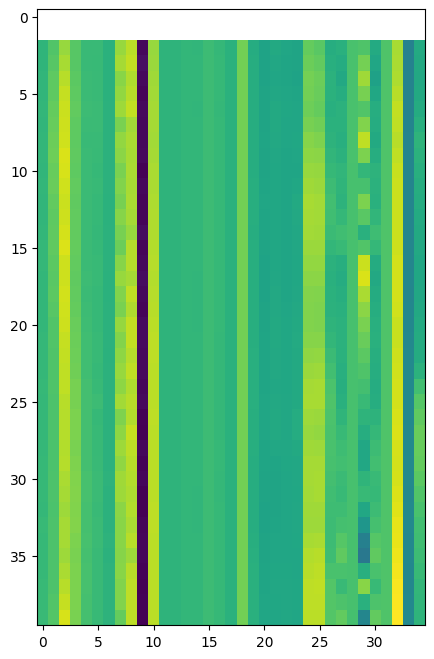

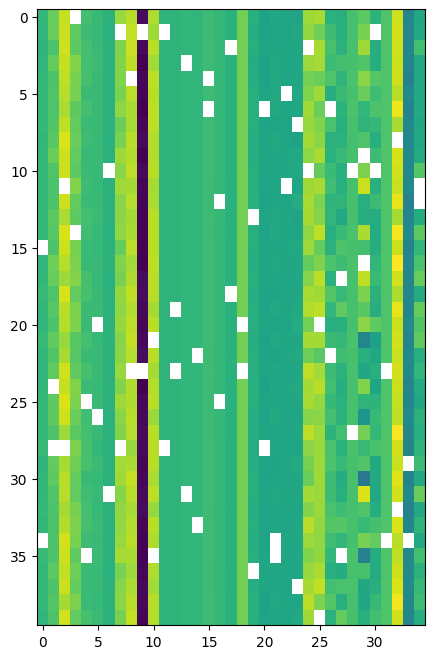

In [22]:
plt.figure(figsize=(5, 8))
plt.imshow(x[0].detach().numpy(), aspect='auto')
plt.show()

plt.figure(figsize=(5, 8))
plt.imshow(x_shuff[0].detach().numpy(), aspect='auto')
plt.show()

torch.Size([16, 40, 35])


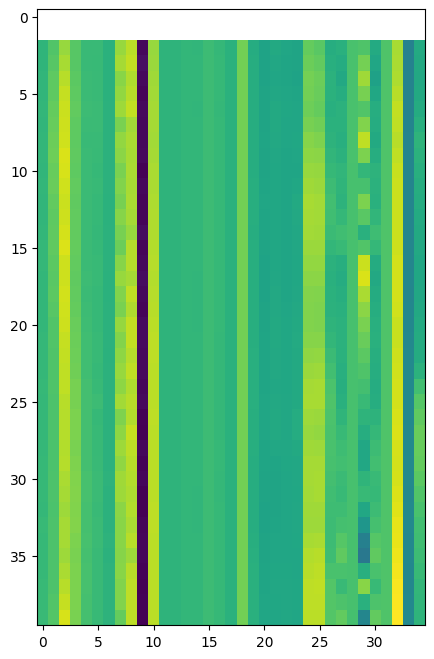

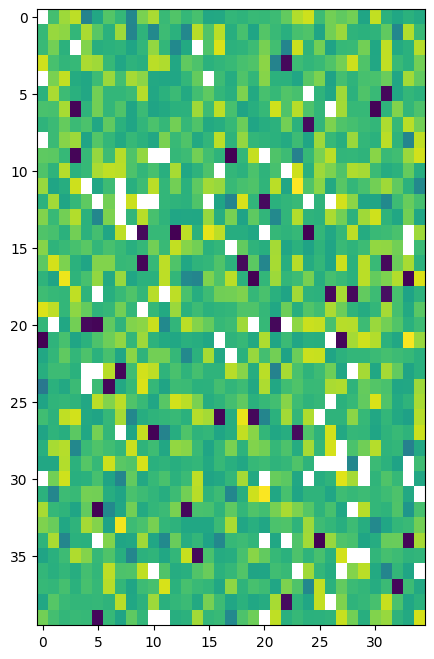

In [31]:
import torch

def topological_shuffle(tensor):
    batch_size, time_steps, d_features = tensor.size()
    shuffled_tensor = tensor.clone()

    for i in range(batch_size):
        indices = torch.randperm(time_steps * d_features)
        shuffled_tensor[i] = tensor[i].view(-1)[indices].view(time_steps, d_features)

    return shuffled_tensor

x_shuff = topological_shuffle(x)
print(x_shuff.shape)

plt.figure(figsize=(5, 8))
plt.imshow(x[0].detach().numpy(), aspect='auto')
plt.show()

plt.figure(figsize=(5, 8))
plt.imshow(x_shuff[0].detach().numpy(), aspect='auto')
plt.show()

In [1]:
import os 

In [7]:
root_to_split_details = '../kfold/splits/'
path_to_augs = '../models/'
for aug in os.listdir(path_to_augs):
    if aug == '.DS_Store': continue
    print(aug)
    path_to_aug_models = os.path.join(path_to_augs, aug)
    print(path_to_aug_models)
    for file in os.listdir(path_to_aug_models):
        print(file)
        split_info_for_models = np.load(os.path.join(root_to_split_details, file))
        train_indices = split_info_for_models['train_indices']
        val_indices = split_info_for_models['val_indices']
        
        break
    break

cnn_unity_topological
../models/cnn_unity_topological
4.pth


In [20]:
root_to_split_details = '../kfold/splits/'
path_to_models_trained_on_diff_augs = '../models/'
file_names = np.array( [i for i in range(50) if i not in [27, 37]] )
split  = np.load(f'{root_to_split_details}fold_{file_names[0]}.npz')
val_indices = split['val_indices']

model


In [41]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
from models import CNNModel
from sklearn import metrics
import torch.nn.functional as F
from datasets import MVTSDataset
from torch.utils.data import DataLoader


# Function to calculate AUC
def roc_auc_score(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

# Function to calculate accuracy
def accuracy(y_true, y_hat):
    y_pred = np.where(y_hat >= 0.5, 1, 0)  # Thresholding at 0.5 to convert into binary predictions
    total_samples = len(y_true)
    correct_predictions = np.sum(y_true == y_pred)
    accuracy_score = correct_predictions / total_samples
    return accuracy_score

# Function to calculate the Brier skill score
def calculate_brier_skill_score(y_true, y_hat):
    brier_score = ((y_true - y_hat) ** 2).mean()
    climatology_brier_score = ((y_true.mean() - y_true) ** 2).mean()
    brier_skill_score = 1 - (brier_score / climatology_brier_score)
    return brier_skill_score

# Function to calculate HSS (Cohen's kappa coefficient)
def hss(y_true, y_hat):
    y_pred = np.where(y_hat >= 0.5, 1, 0)  # Thresholding at 0.5 to convert into binary predictions
    total_samples = len(y_true)
    a = np.sum(y_true == 1)  # Number of true positive predictions
    b = np.sum(y_true == 0)  # Number of true negative predictions
    c = np.sum(y_pred == 1)  # Number of positive predictions
    d = np.sum(y_pred == 0)  # Number of negative predictions
    p0 = (a + b) / total_samples  # Overall agreement
    pe = ((a + c) * (a + b) + (b + d) * (c + d)) / (total_samples ** 2)  # Expected agreement by chance
    hss_score = (p0 - pe) / (1 - pe)  # HSS score
    return hss_score

# Function to calculate TSS (Hanssen & Kuiper's skill score or Peirce skill score)
def tss(y_true, y_hat):
    y_pred = np.where(y_hat >= 0.5, 1, 0)  # Thresholding at 0.5 to convert into binary predictions
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True positives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True negatives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False positives
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False negatives
    hit_rate = tp / (tp + fn)  # True Positive Rate (TPR) or Hit Rate
    false_alarm_rate = fp / (fp + tn)  # False Positive Rate (FPR) or False Alarm Rate
    tss_score = hit_rate - false_alarm_rate  # True Skill Score (TSS)
    return tss_score

# Collect filenames for all 50 models
root_to_split_details = '../kfold/splits/'
path_to_models_trained_on_diff_augs = '../models/'
file_names = np.array( [i for i in range(50) if i not in [27, 37]] )

# Create an empty DataFrame
df = pd.DataFrame()

# Itterate over each augmentation
for aug in os.listdir(path_to_models_trained_on_diff_augs):

    if aug == '.DS_Store': continue

    path_to_model_aug = f'{path_to_models_trained_on_diff_augs}/{aug}/'

    # Initialize lists to store metrics
    running_tss_val = []
    running_auc_val = []
    running_hss_val = []
    running_bss_val = []
    running_acc_val = []


    # Itterate over each model trained on a partuclar split of the data
    for file_name in file_names:

        if file_name == '.DS_Store': continue

        # Load validation data
        split = np.load(f'{root_to_split_details}fold_{file_name}.npz')
        val_indices = split['val_indices']
        val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=len(val_indices), shuffle=False, drop_last=False)
        data_val, _, labels_val = next(iter(val_dataloader))
        data_val = torch.nan_to_num(data_val)
        data_val = data_val.unsqueeze_(1)

        # Load model
        model = CNNModel()
        model_path = f'{path_to_model_aug}/{file_name}.pth'
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()

        # Calculate y_hat and y_true for the validation set
        logits_val = model(data_val)
        probabilities_val = F.softmax(logits_val, dim=1) 
        y_hat_val = probabilities_val[:, 1].detach().numpy() 
        y_true_val = labels_val.detach().numpy()

        # Apply metrics
        tss_val = tss(y_true_val, y_hat_val)
        auc_val = roc_auc_score(y_true_val, y_hat_val)
        hss_val = hss(y_true_val, y_hat_val)
        bss_val = calculate_brier_skill_score(y_true_val, y_hat_val)
        accuracy_val = accuracy(y_true_val, y_hat_val)

        # Append metrics to lists
        running_tss_val.append(tss_val)
        running_auc_val.append(auc_val)
        running_hss_val.append(hss_val)
        running_bss_val.append(bss_val)
        running_acc_val.append(accuracy_val)

        # Append metrics to DataFrame
        row = pd.DataFrame({
            'augmentation': [aug],
            'tss': [tss_val],
            'auc': [auc_val],
            'hss': [hss_val],
            'bss': [bss_val],
            'accuracy': [accuracy_val]
        })
        df = pd.concat([df, row], ignore_index=True)

        del model, logits_val, probabilities_val, y_hat_val, y_true_val, tss_val, auc_val, hss_val, bss_val, accuracy_val, row


In [39]:
df

,augmentation,tss,auc,hss,bss,accuracy
0,cnn_unity_topological,0.000000,0.588339,1.0,-0.088316,0.459016
1,cnn_unity_topological,0.000000,0.601484,1.0,0.011326,0.467213
2,cnn_unity_topological,0.016129,0.590054,1.0,-0.089450,0.500000
3,cnn_unity_topological,0.000000,0.344028,1.0,-0.163229,0.409836
4,cnn_unity_topological,0.002159,0.743590,1.0,0.028639,0.532787
5,cnn_unity_topological,0.016667,0.445968,1.0,-0.057003,0.516393
6,cnn_unity_topological,-0.025131,0.573046,1.0,-0.072940,0.409836
7,cnn_unity_topological,0.029634,0.616918,1.0,-0.004051,0.491803
8,cnn_unity_topological,0.000000,0.501751,1.0,-0.005090,0.475410
9,cnn_unity_topological,-0.018182,0.375848,1.0,-0.052590,0.442623
